In [1]:
# imports
from utils import *

In [2]:
# read the configuration file and initialize random generators
cfg = read_config('config_ANN.yaml')
initalize_random_generators(cfg)

In [3]:
# load dataset 
allData = load_data(cfg['dataset']) #RT: added frac to speed-up trials and debugging

In [4]:
# process dataset (separate features & classes, split in train and test, reduce train size if needed)
X_cv, X_test, y_cv, y_test = data_prep(allData, cfg['features'], cfg['target'],
                                       randomState=cfg['dprep_seed'], 
                                       testSize=cfg['frac_tst'], 
                                       trainSize=cfg['train_size'])

In [5]:
# create folds using smoter (created beforehand to speed-up computation)
smoter = SMOTE(random_state=cfg['smote_seed'], sampling_strategy='auto', 
               k_neighbors = cfg['smote_kneighbors'], n_jobs = -1)
folds = create_folds_with_SMOTE(X_cv, y_cv, n_splits=cfg['n-folds'], smoter=None)

In [6]:
# find best parameters for each algorithm via cross-validation
results = cv_model_selection(folds, cfg)
print(results)

Start cross-validation for RandomForestClassifier
Parameter combination 1/3


  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combination 2/3


  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combination 3/3


  0%|          | 0/5 [00:00<?, ?it/s]

Start cross-validation for LGBMClassifier
Parameter combination 1/3


  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combination 2/3


  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combination 3/3


  0%|          | 0/5 [00:00<?, ?it/s]

Start cross-validation for ANNClassifier
Parameter combination 1/3


  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combination 2/3


  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combination 3/3


  0%|          | 0/5 [00:00<?, ?it/s]

                algorithm                                             params  \
0  RandomForestClassifier  {'max_depth': 5, 'min_samples_leaf': 25, 'min_...   
1  RandomForestClassifier  {'max_depth': 5, 'min_samples_leaf': 25, 'min_...   
2  RandomForestClassifier  {'max_depth': 5, 'min_samples_leaf': 25, 'min_...   
3          LGBMClassifier  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
4          LGBMClassifier  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
5          LGBMClassifier  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...   
6           ANNClassifier  {'act_fun': 'relu', 'batch_size': 4096, 'dropo...   
7           ANNClassifier  {'act_fun': 'relu', 'batch_size': 4096, 'dropo...   
8           ANNClassifier  {'act_fun': 'relu', 'batch_size': 4096, 'dropo...   

                                            f1scores  avg_f1score        time  \
0  [0.8693463477897324, 0.8722035460145732, 0.869...     0.866427   41.717942   
1  [0.8703190191377354, 0.86713537311

In [7]:
# select best params combination for each algorithm
best_ixes = results.groupby('algorithm')['avg_f1score'].idxmax().sort_values().values
best_models = results.loc[best_ixes].reset_index(drop=True)
print(best_models)

                algorithm                                             params  \
0  RandomForestClassifier  {'max_depth': 5, 'min_samples_leaf': 25, 'min_...   
1          LGBMClassifier  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...   
2           ANNClassifier  {'act_fun': 'relu', 'batch_size': 4096, 'dropo...   

                                            f1scores  avg_f1score        time  \
0  [0.8687234968388181, 0.8691831197419839, 0.871...     0.868878  117.132353   
1  [0.8962313251367285, 0.896981280182932, 0.8949...     0.896420   65.981288   
2  [0.853254609523647, 0.8508643197215064, 0.8536...     0.852583   97.067404   

                                           oof_preds  
0  [Faucet, Toilet, Other, Faucet, Faucet, Other,...  
1  [Faucet, Toilet, Other, Faucet, Faucet, Other,...  
2  [Faucet, Toilet, Other, Faucet, Faucet, Other,...  


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

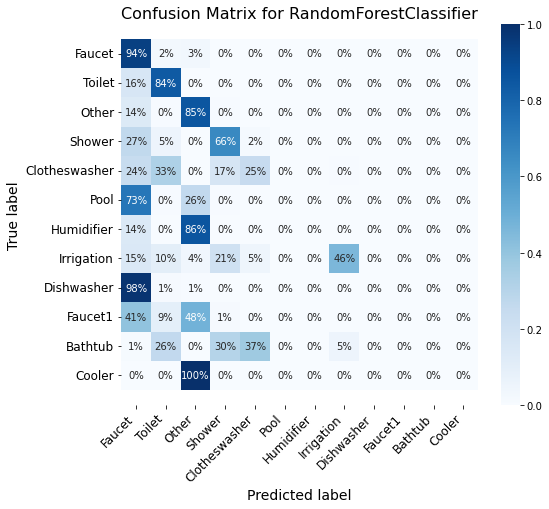

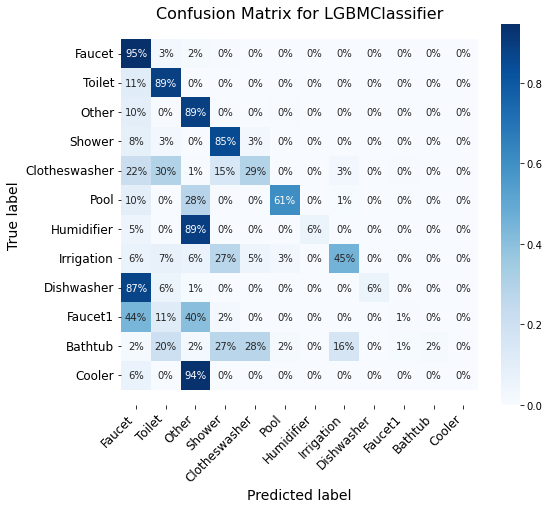

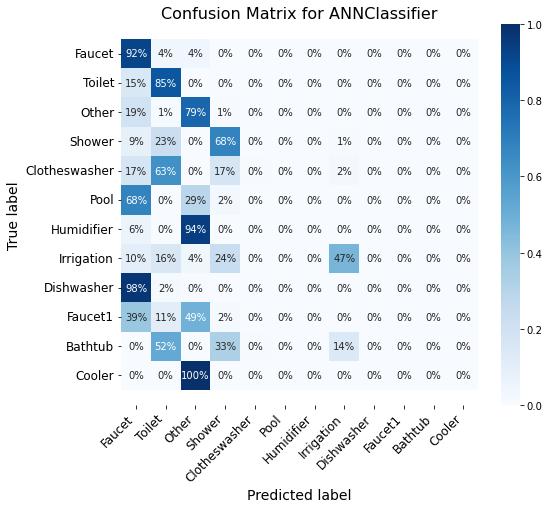

In [8]:
# store all test results for best models and plot confusion matrices
all_tst_preds = pd.DataFrame(columns = best_models['algorithm'])
for ix, row in best_models.iterrows():
    tst_preds, _ = single_model_cv_and_test(folds,row['algorithm'],row['params'],X_test,y_test)    
    _, ax = get_confusion_matrix(y_test, tst_preds, plot=True)
    ax.set_title('Confusion Matrix for '+ row['algorithm'], fontsize=16)
    all_tst_preds[row['algorithm']]=tst_preds


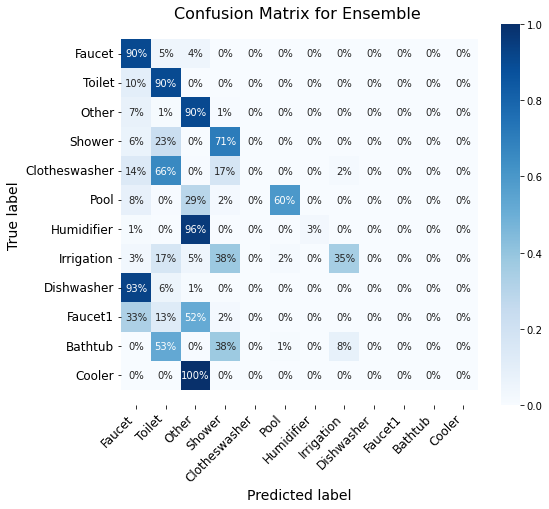

In [10]:
# confusion matrix of majority vote ensemble
ens_preds = all_tst_preds.max(axis=1)
_, ax = get_confusion_matrix(y_test, ens_preds, plot=True)
ax.set_title('Confusion Matrix for Ensemble ', fontsize=16);

In [30]:
# f1 scores
from sklearn.metrics import f1_score

# store all test results for best models and plot confusion matrices
for algorithm in all_tst_preds.columns:
    print(f"{algorithm}\ttest f1_score={f1_score(y_test, all_tst_preds[algorithm], average='micro'):.3f}".expandtabs(30))
    
print(f"{'Ensemble'}\ttest f1_score={f1_score(y_test, ens_preds, average='micro'):.3f}".expandtabs(30))


RandomForestClassifier        test f1_score=0.870
LGBMClassifier                test f1_score=0.897
ANNClassifier                 test f1_score=0.848
Ensemble                      test f1_score=0.866
